input number of days ago: 365
Enter the ticker name: AAPL
Number of Moving averages you want to know :2
enter the 0 th moving average :10
enter the 1 th moving average :30


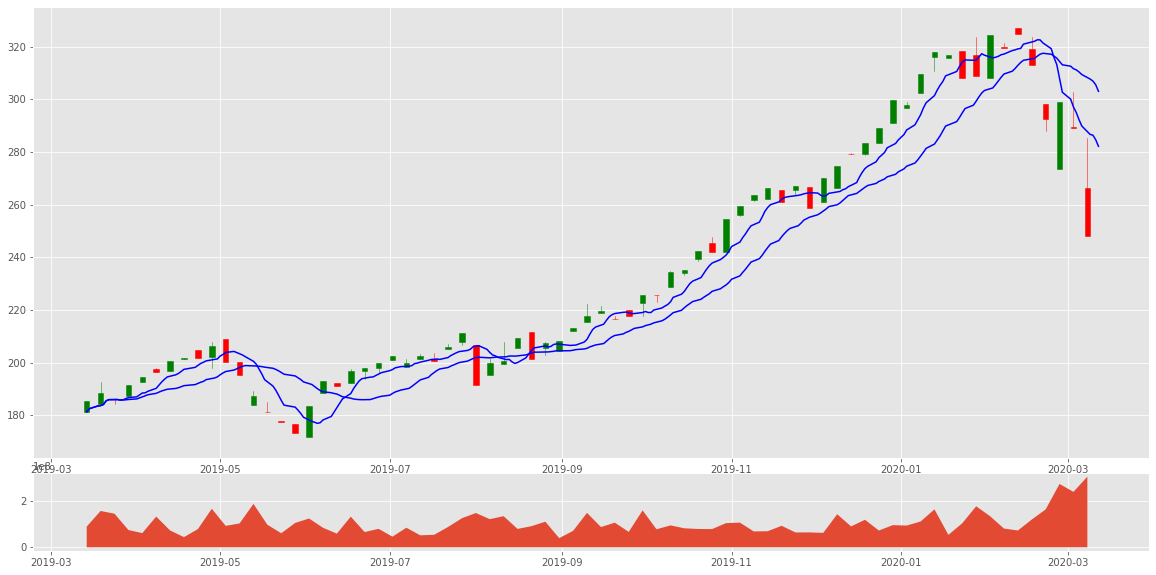

In [57]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
from datetime import timedelta, datetime
import os
%matplotlib inline

def plot_candle_graph():
    N = int(input('input number of days ago: '))
    comp_name = input('Enter the ticker name: ')
    no_of_mavg = int(input('Number of Moving averages you want to know :'))
    avg = []
    for i in range(no_of_mavg):
        z = int(input('enter the {} th moving average :'.format(i)))
        avg.append(z)

    style.use('ggplot')
    end = dt.datetime.now()
    start = dt.datetime.now() - timedelta(days=N)
    df = web.DataReader(comp_name, 'yahoo', start, end)
    df.reset_index(inplace=True)
    df.set_index("Date", inplace=True)
    df.to_csv('{}.csv'.format(comp_name))
    # df = df.drop("Symbol", axis=1)

    df = pd.read_csv('{}.csv'.format(comp_name), parse_dates=True, index_col=0)

    # 100 moving average
    for i in avg:
        df['{}ma'.format(i)] = df['Adj Close'].rolling(window=i, min_periods=0).mean()

    df.dropna(how='any', inplace=True)

    df_ohlc = df['Adj Close'].resample('5D').ohlc()#operated on 'Adj Close'
    #open<-Adj close on 0th day
    #close<-Adj Close on 4th day
    #high<- max Adj Close in 5 days
    #low<-min Adj Close in 5 days

    #df_ohlc[open high low close] of 10 days gaph #df_ohlc is a dataframe 
    df_volume = df['Volume'].resample('5D').sum() #df_volume another dataframe

    df_ohlc.reset_index(inplace=True) #removing dates from index #makes another column of date
    df_ohlc['Date'] = df_ohlc['Date'].map(mdates.date2num)

    plt.figure(figsize=(20, 10))
    ax1 = plt.subplot2grid((6, 1), (0, 0), rowspan=5, colspan=1)
    ax2 = plt.subplot2grid((6, 1), (5, 0), rowspan=5, colspan=1, sharex=ax1)  # sharing the x axis of ax1
    
    ###### plotting candlestick ohlc ####
    ax1.xaxis_date() #ax1 xaxis become real date #otherwise 736900 will be date starter,like mapped date in df_ohlc['Date']
    candlestick_ohlc(ax1, df_ohlc.values, width=2, colorup='g') #imported from mlp_finance "candlestick_ohlc" #xaxis already date
                    #(where to plot,values for candle plot(date,o,h,l,c))
                    #each one like box plot(without), show boxplot theory
                    #high
                    #close(profit)/open(loss)
                    #open(profit)/close(loss)
                    #low
    ####### plotting fill between ####
    ax2.fill_between(df_volume.index.map(mdates.date2num), df_volume.values, 0)#x,y,0(0 to y)
    for i in avg:
        ax1.plot(df.index, df['{}ma'.format(i)], color='blue')
    # ax1.plot(df.index,df['Adj Close'],color='black')
    #os.remove('{}.csv'.format(comp_name)) ###TODO
    plt.show()


plot_candle_graph()


In [58]:
import numpy as np

In [59]:
aapl=pd.read_csv('AAPL.csv')

In [60]:
# Initialize the short and long windows
short_window = 40
long_window = 100

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=aapl.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = aapl['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = aapl['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0) #np.where(condi,false,true)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Print `signals`
print(signals[:50])

    signal  short_mavg   long_mavg  positions
0      0.0  183.729996  183.729996        NaN
1      0.0  184.924995  184.924995        0.0
2      0.0  185.956665  185.956665        0.0
3      0.0  186.099998  186.099998        0.0
4      0.0  186.512000  186.512000        0.0
5      0.0  187.941666  187.941666        0.0
6      0.0  188.385714  188.385714        0.0
7      0.0  188.430000  188.430000        0.0
8      0.0  188.247777  188.247777        0.0
9      0.0  188.270000  188.270000        0.0
10     0.0  188.310909  188.310909        0.0
11     0.0  188.447500  188.447500        0.0
12     0.0  188.662308  188.662308        0.0
13     0.0  189.045000  189.045000        0.0
14     0.0  189.465334  189.465334        0.0
15     0.0  189.854376  189.854376        0.0
16     0.0  190.274707  190.274707        0.0
17     0.0  190.820557  190.820557        0.0
18     0.0  191.277369  191.277369        0.0
19     0.0  191.744501  191.744501        0.0
20     0.0  192.087620  192.087620

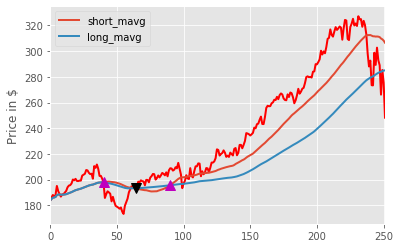

In [61]:
# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
aapl['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()

In [62]:
df=pd.read_csv('AAPL.csv',parse_dates=True, index_col=0)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-03-14,184.100006,182.559998,183.899994,183.729996,23579500.0,181.356216
2019-03-15,187.330002,183.740005,184.850006,186.119995,39042900.0,183.715332
2019-03-18,188.389999,185.789993,185.800003,188.020004,26219800.0,185.590805
2019-03-19,188.990005,185.919998,188.350006,186.529999,31646400.0,184.120056
2019-03-20,189.490005,184.729996,186.229996,188.160004,31035200.0,185.728989


In [63]:
df_ohlc=df['Adj Close'].resample('5D').ohlc() 
#open<-Adj close on 0th day
#close<-Adj Close on 4th day
#high<- max Adj Close in 5 days
#low<-min Adj Close in 5 days
df_ohlc.head()

,open,high,low,close
Date,,,,
2019-03-14,181.356216,185.590805,181.356216,185.590805
2019-03-19,184.120056,192.569427,184.120056,188.581650
2019-03-24,186.301483,186.301483,184.376678,186.281738
2019-03-29,187.495865,191.513290,187.495865,191.513290
2019-04-03,192.826111,194.454758,192.826111,194.454758


In [64]:
df_ohlc.reset_index(inplace=True) 
df_ohlc.head()

,Date,open,high,low,close
0,2019-03-14,181.356216,185.590805,181.356216,185.590805
1,2019-03-19,184.120056,192.569427,184.120056,188.581650
2,2019-03-24,186.301483,186.301483,184.376678,186.281738
3,2019-03-29,187.495865,191.513290,187.495865,191.513290
4,2019-04-03,192.826111,194.454758,192.826111,194.454758


In [65]:
df_ohlc['Date'] = df_ohlc['Date'].map(mdates.date2num)
df_ohlc.head()

,Date,open,high,low,close
0,737132.0,181.356216,185.590805,181.356216,185.590805
1,737137.0,184.120056,192.569427,184.120056,188.581650
2,737142.0,186.301483,186.301483,184.376678,186.281738
3,737147.0,187.495865,191.513290,187.495865,191.513290
4,737152.0,192.826111,194.454758,192.826111,194.454758


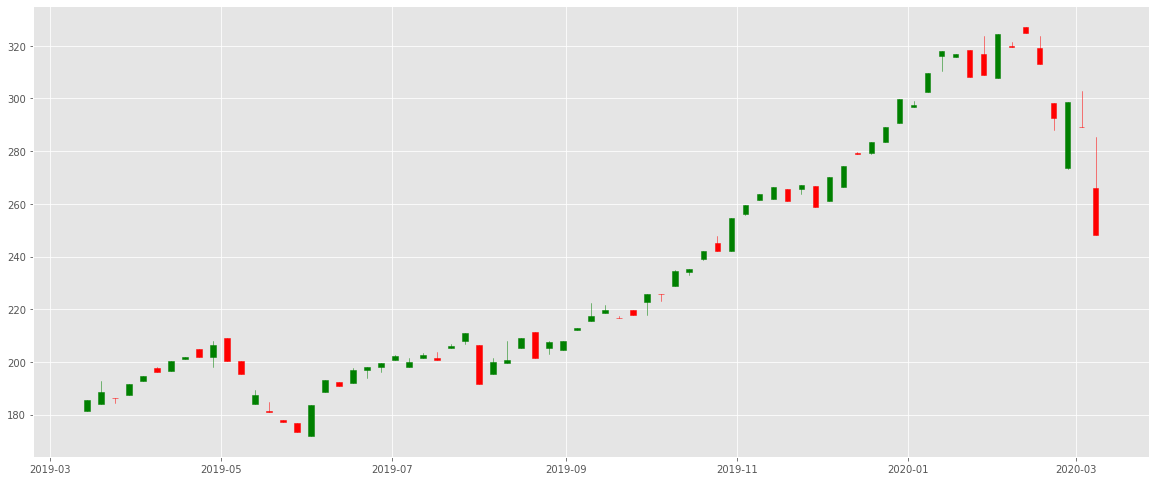

In [66]:
plt.figure(figsize=(20,10))
ax = plt.subplot2grid((6, 1), (0, 0), rowspan=5, colspan=1)
ax.xaxis_date()
candlestick_ohlc(ax, df_ohlc.values, width=2, colorup='g')
plt.show()

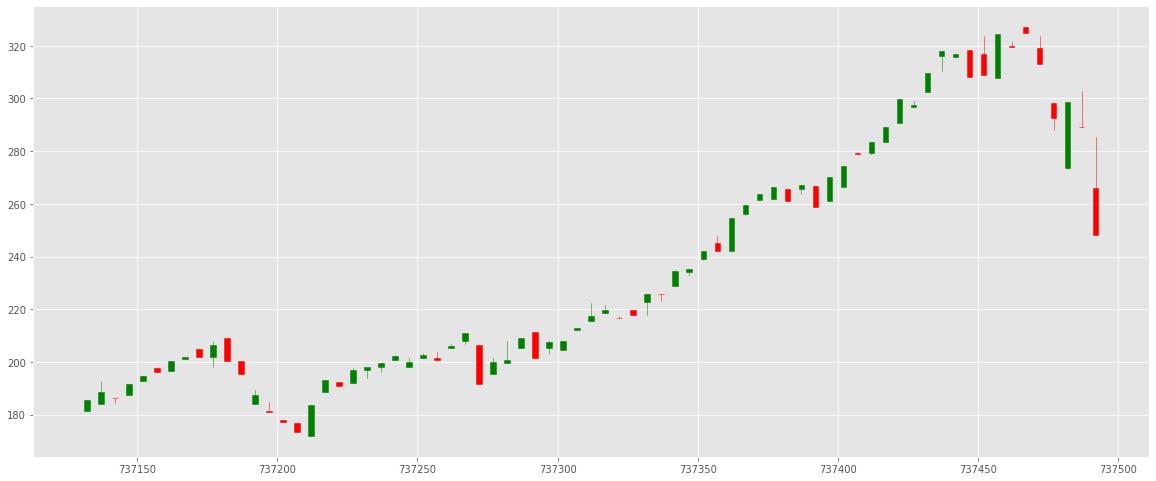

In [67]:
plt.figure(figsize=(20,10))
ax = plt.subplot2grid((6, 1), (0, 0), rowspan=5, colspan=1)
#ax.xaxis_date() abnormal date in x axix
candlestick_ohlc(ax, df_ohlc.values, width=2, colorup='g')
plt.show()